In [69]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [70]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [71]:
len(words)

32033

In [72]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [73]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [74]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad) # allclose checks for approximate equality 
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [75]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [76]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [77]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() #-logprobs[range(n), Yb] pluck out the pronability of the correct next character out of 27 probabilities for each char

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3312, grad_fn=<NegBackward0>)

In [78]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# loss= -(a+b+c)/3
# dloss/da = -1/3
#for n numbers dloss/dx = -1/n
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
cmp('logprobs', dlogprobs, logprobs)

# logprobs = probs.log()
# derivative of log(x) is 1/x
dprobs= (1/probs)*dlogprobs 
cmp('probs', dprobs, probs)

# probs = counts * counts_sum_inv
# counts shape 32 x 27, counts_sum_inv shape 32 x 1
#c=a * b, but with tensors:
# a [3x3] * b[3,1] -=>
# all*bl a12*bl a13*bl
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]
# b1 is using multiple times so for gradient we will sum it up
dcounts_sum_inv = (counts*dprobs).sum(1, keepdims=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts = counts_sum_inv*dprobs
#counts_sum_inv = counts_sum**-1
#derivative of x^-1 is -1/x^2
dcounts_sum= -1/(counts_sum**2)*dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)


# counts_sum = counts.sum(1, keepdims=True) #sum along the row
# from [32,27] to [32,1]
#eg: b1=a11+a12+a13
dcounts += torch.ones_like(counts)*dcounts_sum
cmp('counts', dcounts, counts)

# counts = norm_logits.exp()
dnorm_logits = counts*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

# norm_logits = logits - logit_maxes
dlogits = dnorm_logits
dlogit_maxes = -(dnorm_logits).sum(1, keepdims=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

#logit_maxes = logits.max(1, keepdim=True).values
#derivative of max is 1
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogit_maxes
cmp('logits', dlogits, logits)

# logits = h @ W2 + b2
dh= dlogits @ W2.T  #you can check the shape of W2.T is [27,64] and dlogits is [32,27] and hence the multiplication is possible
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

# h = torch.tanh(hpreact) # hidden layer
# derivative: a=tanh(x), d/dx= 1-a^2
dhpreact = (1-h**2)*dh
cmp('hpreact', dhpreact, hpreact)

# hpreact = bngain * bnraw + bnbias
# [32,64] = [1,64] * [32,64] + [1,64]
dbngain = (bnraw*dhpreact).sum(0, keepdims=True)
dbnbias = dhpreact.sum(0, keepdims=True)
dbnraw = bngain*dhpreact
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

# bnraw = bndiff * bnvar_inv
# [32,64] = [32,64] * [1,64]
dbnvar_inv= (bndiff *dbnraw).sum(0, keepdims=True)
dbndiff = bnvar_inv * dbnraw
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
# derivative of x^-0.5 is -0.5*x^-1.5
dbnvar= -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# [1,64] = [32,64] shapes
dbndiff2=(1/(n-1)*torch.ones_like(bndiff2))*dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

# bndiff2 = bndiff**2
# [32,64] = [32,64] * [32,64]
dbndiff += 2*bndiff*dbndiff2
cmp('bndiff', dbndiff, bndiff)

# bndiff = hprebn - bnmeani
# [32,64] = [32,64] - [1,64]
dhprebn = dbndiff
dbnmeani = -dbndiff.sum(0, keepdims=True)
cmp('bnmeani', dbnmeani, bnmeani)

# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# [1,64] = [32,64]
dhprebn += 1/n*torch.ones_like(hprebn)*dbnmeani
cmp('hprebn', dhprebn, hprebn)

# hprebn = embcat @ W1 + b1
# [32,64] = [32,270] @ [270,64] + [1,64]
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdims=True)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# [32,270] = [32,27*10]
demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

# emb = C[Xb]
# [32,27,10] = C:[27,10] | Xb:[32,3]
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for i in range(Xb.shape[1]):
    ix=Xb[k,i]
    dC[ix] += demb[k,i]

# dC.index_add_(0, Xb.view(-1), demb.view(-1, n_embd)) #alternate way
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [79]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3311614990234375 diff: -2.384185791015625e-07


In [80]:
# backward pass

dlogits=F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits)

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


torch.Size([1, 27]) torch.Size([32])
tensor([6.3598e-01, 9.1604e-02, 1.1415e-03, 4.1567e-03, 3.9364e-04, 2.9427e-02,
        8.0384e-04, 6.6809e-04, 1.6578e-02, 2.3743e-02, 4.3779e-04, 2.5272e-03,
        7.5931e-02, 3.0232e-03, 8.6748e-04, 2.2101e-02, 1.6891e-03, 2.0332e-05,
        2.2860e-03, 5.7865e-03, 4.8461e-02, 3.4812e-03, 1.5034e-03, 5.2772e-04,
        1.6534e-02, 8.1544e-03, 2.1717e-03], grad_fn=<SelectBackward0>)
tensor([ 1.6588e-03,  2.8774e-02,  3.1510e-03,  2.8917e-03,  5.6129e-03,
         5.0518e-02,  1.2597e-03,  4.6285e-03,  1.0317e-02,  1.1213e-01,
         6.3118e-04,  2.4168e-03,  1.2453e-01,  4.2494e-02, -6.4382e-01,
         2.7401e-02,  4.1702e-03,  8.9537e-05,  3.8730e-02,  5.2606e-02,
         9.0259e-03,  1.1085e-03,  1.5730e-02,  2.6811e-03,  2.8019e-04,
         9.2415e-02,  8.5616e-03])
tensor(-2.7940e-09)


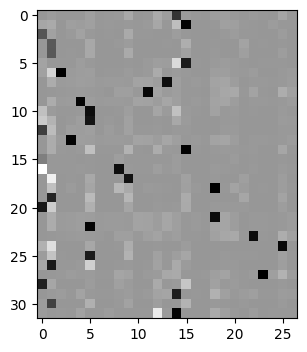

In [90]:
print(logits.shape, Yb.shape)
print(F.softmax(logits, 1)[0])
print(dlogits[0] * n)
print(dlogits[0].sum())

plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [81]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [82]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n *(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [86]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.8544
  10000/ 200000: 2.1853
  20000/ 200000: 2.4085
  30000/ 200000: 2.4439
  40000/ 200000: 2.0044
  50000/ 200000: 2.3760
  60000/ 200000: 2.3248
  70000/ 200000: 2.0754
  80000/ 200000: 2.2557
  90000/ 200000: 2.1446
 100000/ 200000: 2.0004
 110000/ 200000: 2.3373
 120000/ 200000: 2.0105
 130000/ 200000: 2.4582
 140000/ 200000: 2.2578
 150000/ 200000: 2.1827
 160000/ 200000: 1.9645
 170000/ 200000: 1.8881
 180000/ 200000: 2.0159
 190000/ 200000: 1.9017


In [ ]:
# #for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [87]:
#calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [88]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0727484226226807
val 2.112144708633423


In [89]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mri.
reetlanna.
sane.
mahnen.
delynn.
jareei.
ner.
kiah.
maiiv.
kaleigh.
ham.
joce.
quint.
saline.
liven.
coraelo.
dearynix.
